In [ ]:
#@markdown # 개발 환경 확인
!nvidia-smi

#@markdown ---

Sun Sep 24 13:11:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#@markdown # 개발 환경 셋업
from IPython.utils import capture
from IPython.display import clear_output
import ipywidgets as widgets

def inf(msg, style, wdth): inf = widgets.Button(description=msg, disabled=True, button_style=style, layout=widgets.Layout(min_width=wdth));display(inf)

with capture.capture_output() as cap:
  !npm install localtunnel
  !pip install diffusers transformers scipy ftfy numpy
  !pip install "ipywidgets>=7,<8"
  !pip install streamlit streamlit-chat
  !pip install bardapi
  !pip install requests

clear_output()
inf('\u2714 Done','success', '50px')
#@markdown ---

Button(button_style='success', description='✔ Done', disabled=True, layout=Layout(min_width='50px'), style=But…

In [ ]:
#@markdown # Hugging Face 로그인
from google.colab import output
from huggingface_hub import notebook_login

output.enable_custom_widget_manager()
notebook_login()

#@markdown ---

In [ ]:
#@markdown # Streamlit 어플리케이션 작성
%%writefile app.py

import json
import re
import requests
import streamlit as st
import torch
from bardapi.constants import SESSION_HEADERS
from bardapi import Bard
from diffusers import StableDiffusionPipeline
from PIL import Image
from streamlit_chat import message
from torch import autocast

MODEL = "runwayml/stable-diffusion-v1-5"
# MODEL = "CompVis/stable-diffusion-v1-4"

st.header("Service (" + MODEL + ")")

session = requests.Session()
session.headers = SESSION_HEADERS

if 'psid' not in st.session_state:
    st.session_state['psid'] = ""

if 'psidts' not in st.session_state:
    st.session_state['psidts'] = ""

if 'psidcc' not in st.session_state:
    st.session_state['psidcc'] = ""

if 'pipe' not in st.session_state:
    st.session_state['pipe'] = ""

if 'prompt' not in st.session_state:
    st.session_state['prompt'] = "선글라스 쓰고 당근을 먹으면서 컴퓨터로 만들어진 이진 세상을 즐겁게 여행하는 토끼, 일러스트 스타일, 파란 바탕"

def get_json(json_string):
    json_string = json_string.replace('\n', ' ')
    result = re.search('```json(.*)```', json_string)
    if result:
      return json.loads(result.group(1))
    return json.loads(json_string)

def generate_prompt_for_stable_diffusion(prompt):
  session.cookies.set("__Secure-1PSID", st.session_state.psid)
  session.cookies.set("__Secure-1PSIDTS", st.session_state.psidts)
  session.cookies.set("__Secure-1PSIDCC", st.session_state.psidcc)

  bard = Bard(token=st.session_state.psid, session=session)
  prompt_for_generating_stable_diffusion_prompt = '\
  {"role": "system", "content": "Output only valid JSON"},\
  {"role": "user", "content": "\
    I want you to help me make prompts for the Stable Diffusion.\
    Stable Diffusion is a text-based image generation model that can create diverse and high-quality images based on users\' requests.\
    In order to get the best results from Stable diffusion, you need to follow some guidelines when composing prompts.\
    Here are some tips for writing prompts for Stable Diffusion:\
    1. Be as specific as possible in the requests. Stable diffusion handles concrete prompts better than abstract or ambiguous ones. For example, instead of \\"portrait of a woman,\\" it is better to write \\"portrait of a Korean woman with brown eyes and red hair in Renaissance style.\\"\
    2. Specify specific art styles or materials. If you want to get an image in a certain style or with a certain texture, then specify this in the request. For example, instead of \\"landscape,\\" it is better to write \\"watercolor landscape with mountains and lake.\\"\
    3. Specify specific artists for reference. If you want to get an image similar to the work of some artist, then specify his name in the request. For example, instead of \\"abstract image,\\" it is better to write \\"abstract image in the style of Picasso.\\"\
    4. Don\'t use any pronouns.\
    5. Avoid using thesr words: in a, a, an, the, with, of, and, is, of, by\
    6. Weigh your keywords. You can use token:1.3 to specify the weight of keywords in your query.\
    The greater the weight of the keyword, the more it will affect the result. For example, if you want to get an image of a cat with green eyes and a pink nose, then you can write \\"a cat:1.5, green eyes:1.3, pink nose:1.\\" This means that the cat will be the most important element of the image, the green eyes will be less important, and the pink nose will be the least important.\
    Another way to adjust the strength of a keyword is to use () and []. (keyword) increases the strength of the keyword by 1.1 times and is equivalent to (keyword:1.1). [keyword] reduces the strength of the keyword by 0.9 times and corresponds to (keyword:0.9).\
    You can use several of them, as in algebra... The effect is multiplicative.\
    (keyword): 1.1\
    ((keyword)): 1.21\
    (((keyword))): 1.33\
    Similarly, the effects of using multiple [] are as follows\
    [keyword]: 0.9\
    [[keyword]]: 0.81\
    [[[keyword]]]: 0.73\
    I will also give some examples of good prompts for Stable Diffusion so that you can study them and focus on them.\
    Examples:\
    a cute kitten made out of metal, (cyborg:1.1), ([tail | detailed wire]:1.3), (intricate details), hdr, (intricate details, hyperdetailed:1.2), cinematic shot, vignette, centered\
    medical mask, victorian era, cinematography, intricately detailed, crafted, meticulous, magnificent, maximum details, extremely hyper aesthetic.\
    a Korean girl, wearing a tie, cupcake in her hands, school, indoors, (soothing tones:1.25), (hdr:1.25), (artstation:1.2), dramatic, (intricate details:1.14), (hyperrealistic 3d render:1.16), (filmic:0.55), (rutkowski:1.1), (faded:1.3)\
    Jane Eyre with headphones, natural skin texture, 24mm, 4k textures, soft cinematic light, adobe lightroom, photolab, hdr, intricate, elegant, highly detailed, sharp focus, ((((cinematic look)))), soothing tones, insane details, intricate details, hyperdetailed, low contrast, soft cinematic light, dim colors, exposure blend, hdr, faded\
    a portrait of a laughing, toxic, muscle, god, elder, (hdr:1.28), bald, hyperdetailed, cinematic, warm lights, intricate details, hyperrealistic, dark radial background, (muted colors:1.38), (neutral colors:1.2)\
    My query may be in other languages. In that case, translate it into English. Your answer is exclusively in English (IMPORTANT!!!), since the model only understands English.\
    And the token length of the generated prompt must not be more than 73. The token length is measured relative to the length when using the CLIP model.\
    Also, you should not copy my request directly in your response, you should compose a new one, observing the format given in the examples.\
    Finally, give three prompts always like [\\"prompt_1\\", \\"prompt_2\\", \\"prompt_3\\"].\
    Don\'t add your comments, but answer right away.\
    If you are ready, just let me know.\
    User question: ' + prompt + '\
    Format: {{\\"prompts\": [\\"prompt_1\\", \\"prompt_2\\", \\"prompt_3\\"]}}}'
  response = bard.get_answer(prompt_for_generating_stable_diffusion_prompt)

  message(response['content'], key="2")
  return get_json(response['content'])['prompts']

with st.form('form', clear_on_submit = True):
  st.session_state.psid = st.text_input('1PSID: ', st.session_state.psid, type = "password")
  st.session_state.psidts = st.text_input('1PSIDTS: ', st.session_state.psidts, type = "password")
  st.session_state.psidcc = st.text_input('1PSIDCC: ', st.session_state.psidcc, type = "password")
  st.session_state.prompt = st.text_input("Prompt: ", st.session_state.prompt)
  submitted = st.form_submit_button('Generate')

if submitted:
  genereted_prompts = []
  with st.spinner("Generating Stable Diffusion Prompt ..."):
    genereted_prompts = generate_prompt_for_stable_diffusion(st.session_state.prompt)

  if st.session_state.pipe == "":
    with st.spinner("Loading " + MODEL + "..."):
      # make sure you're logged in with `huggingface-cli login`
      st.session_state.pipe = StableDiffusionPipeline.from_pretrained(MODEL, revision="fp16", torch_dtype=torch.float16, use_auth_token=True)
      st.session_state.pipe = st.session_state.pipe.to("cuda")

  num_rows = 1
  num_cols = 3
  all_images = []
  with st.spinner("Generating " + st.session_state.prompt + "..."):
    for i in range(num_rows):
      with autocast("cuda"):
        image = st.session_state.pipe(genereted_prompts, guidance_scale=8.0, num_inference_steps=25, height=512, width=512).images
      all_images.extend(image)

  col1, col2, col3 = st.columns(3)
  with col1:
    st.image(all_images[0], caption = genereted_prompts[0], use_column_width="auto", clamp=False, channels="RGB", output_format="auto")

  with col2:
    st.image(all_images[1], caption = genereted_prompts[1], use_column_width="auto", clamp=False, channels="RGB", output_format="auto")

  with col3:
    st.image(all_images[2], caption = genereted_prompts[1], use_column_width="auto", clamp=False, channels="RGB", output_format="auto")

#@markdown ---

Writing app.py


In [ ]:
#@markdown # 웹 어플리케이션 구동
#@markdown ##### /content/logs.txt External URL 주소 필요
!streamlit run /content/app.py &>/content/logs.txt &
!npx localtunnel --port 8501

#@markdown ---

npx: installed 22 in 1.889s
your url is: https://open-squids-sing.loca.lt
/root/.npm/_npx/959/lib/node_modules/localtunnel/bin/lt.js:81
    throw err;
    ^

Error: connection refused: localtunnel.me:43667 (check your firewall settings)
    at Socket.<anonymous> (/root/.npm/_npx/959/lib/node_modules/localtunnel/lib/TunnelCluster.js:52:11)
    at Socket.emit (events.js:315:20)
    at emitErrorNT (internal/streams/destroy.js:106:8)
    at emitErrorCloseNT (internal/streams/destroy.js:74:3)
    at processTicksAndRejections (internal/process/task_queues.js:80:21)


In [ ]:
#@markdown # 개발 편의용 코드
#@markdown ##### 개발 편의성 향상을 위해 Python 으로 실행
#@markdown ##### 모델 로드
import torch
from diffusers import StableDiffusionPipeline
from PIL import Image
from torch import autocast

def image_grid(imgs, rows, cols):
  assert len(imgs) == rows* cols

  w, h = imgs[0].size
  grid = Image.new('RGB', size=(cols*w, rows*h))
  grid_w, grid_h = grid.size

  for i, img in enumerate(imgs):
    grid.paste(img, box=(i%cols*w, i//cols*h))
  return grid

pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", revision="fp16", torch_dtype=torch.float16, use_auth_token=True)
pipe = pipe.to("cuda")

#@markdown ---

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

vae/diffusion_pytorch_model.safetensors not found


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


  0%|          | 0/25 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


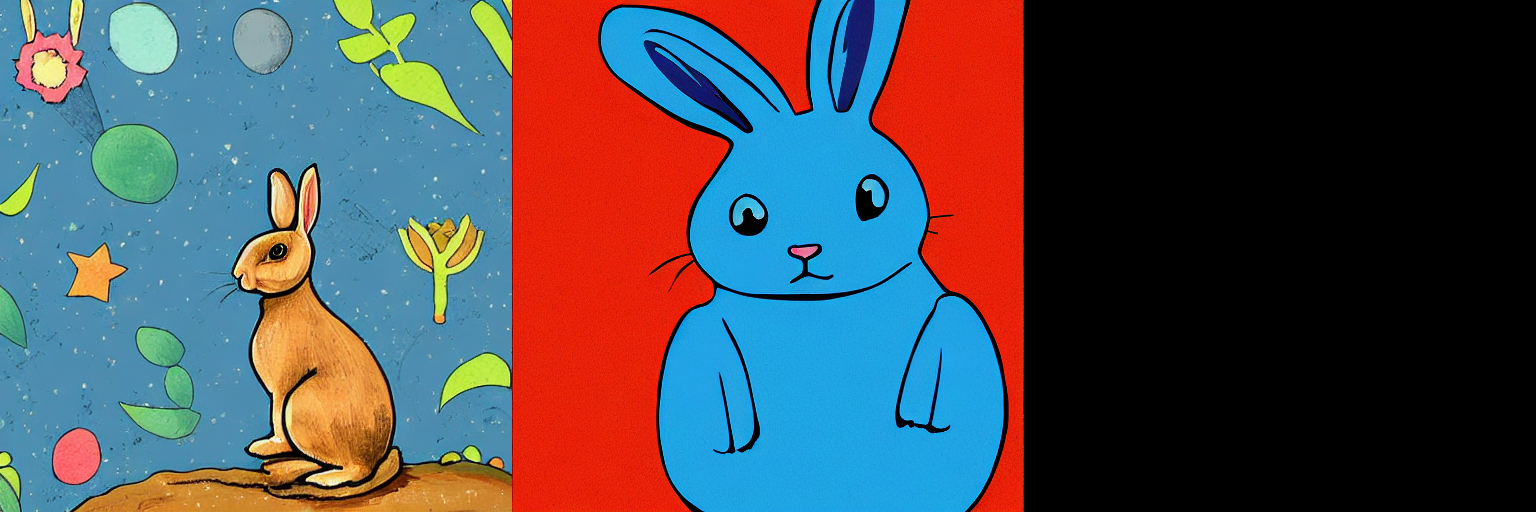

In [ ]:
#@markdown ##### 모델 실행 코드
num_rows = 1
num_cols = 3
all_images = []

prompt = "A bunny on a blue background"
style = ", illustration, poster, anime"
prompt = prompt + style
prompts = [prompt] * num_cols

for i in range(num_rows):
  with autocast("cuda"):
    image = pipe(prompts, num_inference_steps=25, height=512, width=512).images
  all_images.extend(image)

grid = image_grid(all_images, rows = num_rows, cols = num_cols)
grid

#@markdown ---